In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [18]:
#The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.
#Pulling the PJM East which has data from 2002-2018 for the entire east region.

In [5]:
datafile = "/content/drive/MyDrive/Machine Leaning/AEP_hourly.csv"

In [19]:
pjme = pd.read_csv(datafile, index_col=[0], parse_dates=[0])
pjme.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [20]:
pjme.shape

(121273, 1)

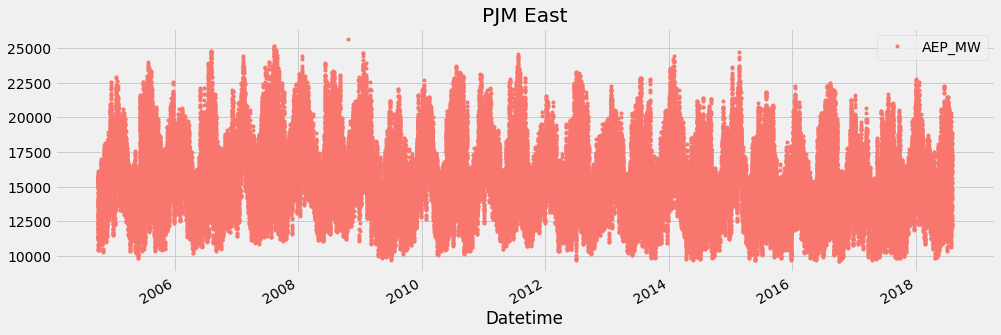

In [21]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [22]:
#Cut off the data after 2015 to use as our validation set.
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [23]:
pjme_train.shape

(89834, 1)

In [24]:
pjme_test.shape

(31439, 1)

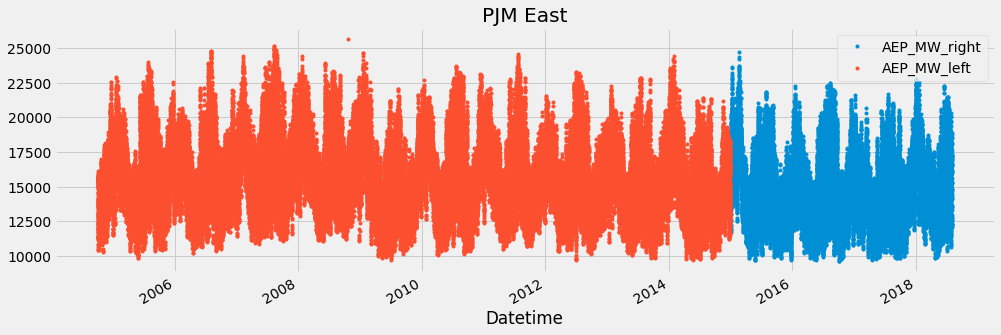

In [30]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer', lsuffix='_right', rsuffix='_left') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [39]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [42]:
X_train, y_train = create_features(pjme_train, label='AEP_MW')
X_test, y_test = create_features(pjme_test, label='AEP_MW')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [45]:
X_train.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2014-01-01 20:00:00,20,2,1,1,2014,1,1,1
2014-01-01 21:00:00,21,2,1,1,2014,1,1,1
2014-01-01 22:00:00,22,2,1,1,2014,1,1,1
2014-01-01 23:00:00,23,2,1,1,2014,1,1,1
2014-01-02 00:00:00,0,3,1,1,2014,2,2,1


In [46]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[12:45:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

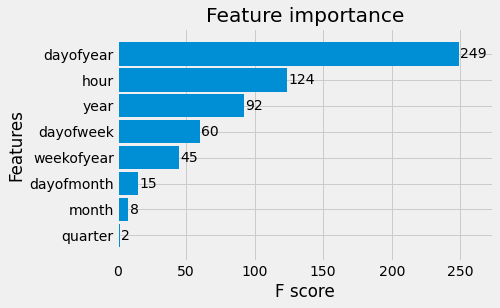

In [48]:
#Feature Importances
#Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. 
#This is a metric that simply sums up how many times each feature is split on.

#We can see that the day of year was most commonly used to split trees, while hour and year came in next. 
#Quarter has low importance due to the fact that it could be created by different dayofyear splits.

_ = plot_importance(reg, height=0.9)


In [54]:
#Forecast on Test Set

pjme_test['AE_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

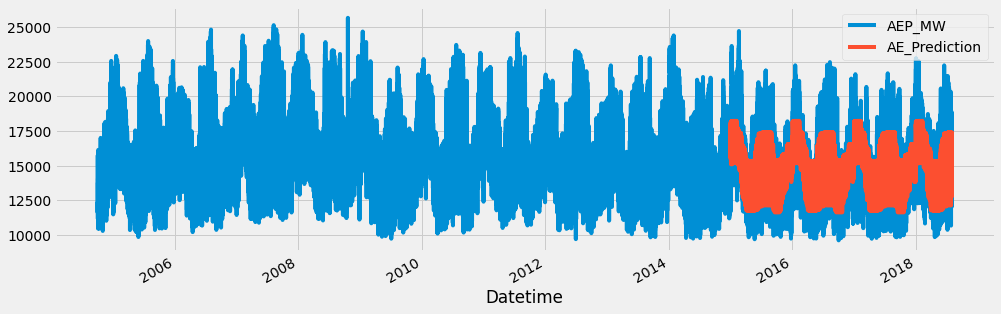

In [55]:
_ = pjme_all[['AEP_MW','AE_Prediction']].plot(figsize=(15, 5))

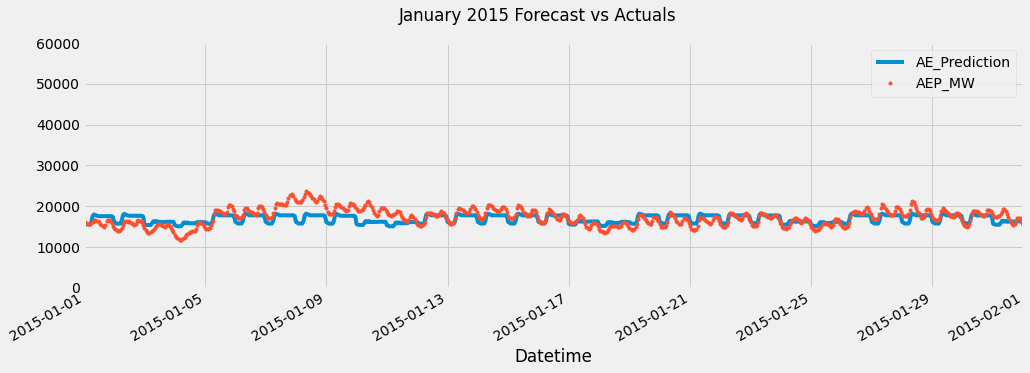

In [58]:
#Look at first month of predictions

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['AE_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')


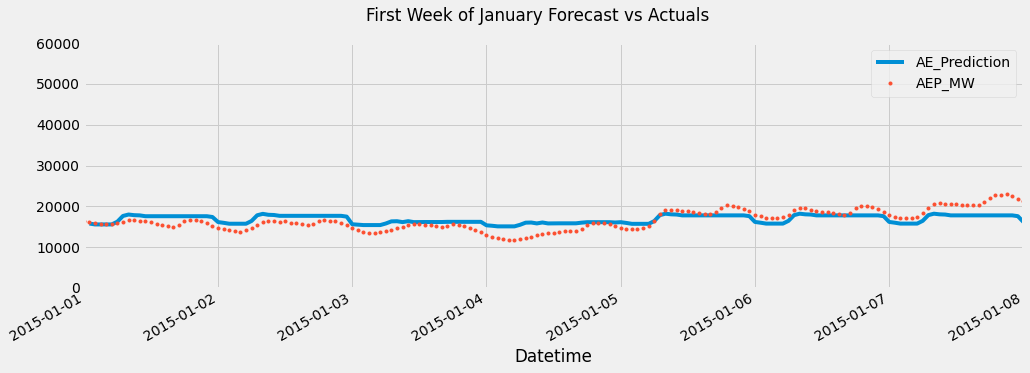

In [60]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['AE_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

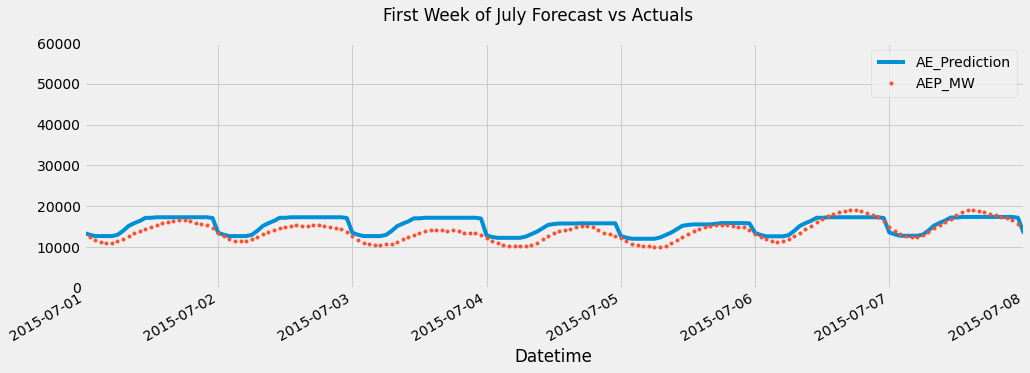

In [62]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['AE_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015') # for range in plot data
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [64]:
#Error Metrics On Test Set

#Our RMSE error is 13780445
#Our MAE error is 2848.89
#Our MAPE error is 8.9%

mean_squared_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['AE_Prediction'])


2698095.2332765916

In [65]:
mean_absolute_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['AE_Prediction'])

1322.3905593657062

In [66]:
#I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. 
#MAPE isn't included in sklearn so we need to use a custom function.

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [67]:
mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['AE_Prediction'])

9.028372403081034

In [68]:
#Look at Worst and Best Predicted Days

pjme_test['error'] = pjme_test['AEP_MW'] - pjme_test['AE_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['AEP_MW','AE_Prediction','error','abs_error']]

In [69]:
error_by_day.sort_values('error', ascending=True).head(10)


AEP_MW  AE_Prediction        error    abs_error
year month dayofmonth                                                       
2015 12    25          11078.041667   15478.911133 -4400.869507  4400.869507
           24          11466.041667   15560.216797 -4094.175578  4094.175578
2017 1     2           13478.583333   17262.708984 -3784.126546  3784.126546
2016 7     4           12048.000000   15660.097656 -3612.097778  3612.097778
2017 1     22          12295.541667   15824.817383 -3529.275431  3529.275431
2015 11    26          11718.500000   15172.686523 -3454.186646  3454.186646
2017 2     12          12408.791667   15824.817383 -3416.025431  3416.025431
2015 11    27          11755.083333   15091.380859 -3336.297241  3336.297241
2017 2     19          12189.541667   15500.613281 -3311.071330  3311.071330
2016 12    26          12242.375000   15543.967773 -3301.593221  3301.593221

In [70]:
#Notice anything about the over forecasted days?

#1 worst day - July 4th, 2016 - is a holiday.
#3 worst day - December 25, 2015 - Christmas
#5 worst day - July 4th, 2016 - is a holiday.
#Looks like our model may benefit from adding a holiday indicator.

In [72]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)


AEP_MW  AE_Prediction        error    abs_error
year month dayofmonth                                                       
2015 2     19          22249.500000   16607.539062  5641.961873  5641.961873
           20          22047.041667   16606.662109  5440.380249  5440.380249
2018 1     6           20847.833333   15997.856445  4849.976685  4849.976685
2015 1     8           21873.333333   17278.958984  4594.374430  4594.374430
     2     16          21129.791667   16672.316406  4457.474894  4457.474894
     12    25          11078.041667   15478.911133 -4400.869507  4400.869507
           24          11466.041667   15560.216797 -4094.175578  4094.175578
2018 1     7           19803.375000   15744.356445  4059.018840  4059.018840
2015 2     15          19695.958333   15694.927734  4001.030884  4001.030884
2017 12    31          18381.750000   14407.993164  3973.756673  3973.756673

In [ ]:
#look error max is owrst predicted

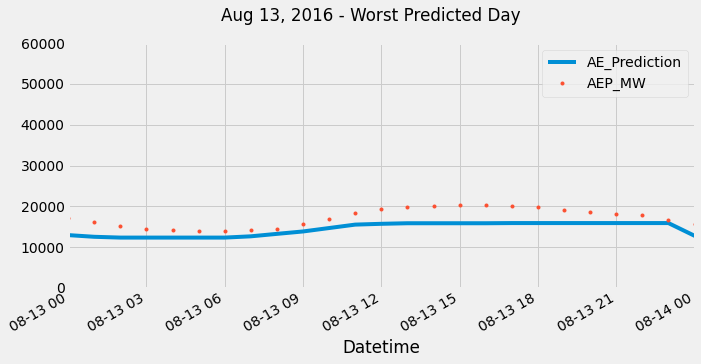

In [74]:
#Plotting some best/worst predicted days

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['AE_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

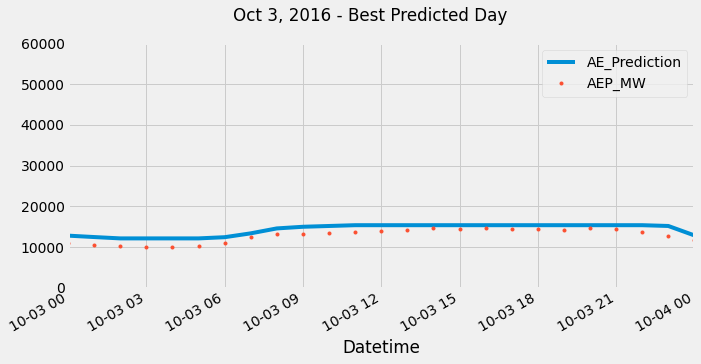

In [75]:
#This one is pretty impressive. SPOT ON!

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['AE_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

In [76]:
#pola diatas hampir mendekati, sangat bagus prediksinya